# Spam Vs Ham Classifier

This notebook corresponds to excercise #4 of the book, we will use the Apache Spam assasing corpus https://spamassassin.apache.org/old/publiccorpus/.

I'm going to work with:
* 20021010_spam.tar.bz2 (Contains emails flagged as spam)
* 20021010_easy_ham.tar.bz2 (Contains easily recognizable ham emails)
* 20021010_hard_ham.tar.bz2 (Contains ham emails but can be mistaken with spam)

## Data exploration
Let's see the content of these folders.


In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_URL = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_URL + "20021010_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_URL + "20021010_spam.tar.bz2"
DATASETS_PATH = os.path.join('./', 'spamham')

def fetch_data(files, datasets_path=DATASETS_PATH):
    if not files:
        raise ValueError("You must provide the files to download")
    
    if type(files) != tuple:
        if type(files) == list and type(files[0]) != tuple:
            raise ValueError("The files must be a tuple or list of tuples e.g.: ('filename', 'url') or [('filename', 'url')]")
                
    if not os.path.isdir(datasets_path):
        os.makedirs(datasets_path)
        
    for filename, url in files:
        path = os.path.join(datasets_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=DATASETS_PATH)
        tar_bz2_file.close()

In [2]:
files = [
    ('ham.tar.bz2', HAM_URL),
    ('spam.tar.bz2', SPAM_URL)
]

fetch_data(files)

In [3]:
HAM_DIR = os.path.join(DATASETS_PATH, 'easy_ham')
SPAM_DIR = os.path.join(DATASETS_PATH, 'spam')

ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [4]:
print("Ham samples: ", len(ham_filenames))
print("Spam samples: ", len(spam_filenames))

Ham samples:  2551
Spam samples:  501


In [5]:
import email
import email.policy

def load_email(is_spam, filename, path=DATASETS_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(DATASETS_PATH, directory, filename), 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [6]:
ham_emails = [load_email(False, name) for name in ham_filenames]
spam_emails = [load_email(True, name) for name in spam_filenames]

### This is a ham email

In [11]:
print(ham_emails[0].get_content().strip())

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 

### Now this is a spam

In [18]:
print(spam_emails[6].get_content().strip())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 
 
  GET IN WITH THE FOUNDERS! 
The MAJOR PLAYERS are on This ONE
For ONCE be where the PlayerS are
This is YOUR Private Invitation

EXPERTS ARE CALLING THIS THE FASTEST WAY 
TO HUGE CASH FLOW EVER CONCEIVED
Leverage $1,000 into $50,000 Over and Over Again

THE QUESTION HERE IS:
YOU EITHER WANT TO BE WEALTHY 
OR YOU DON'T!!!
WHICH ONE ARE YOU?
I am tossing you a financial lifeline and for your sake I 
Hope you GRAB onto it and hold on tight For the Ride of youR life!

Testimonials

Hear what average people are doing their first few days:
�We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL
 �I'm a single mother in FL and I've received 12,000 in the last 4 days.� D. S. in FL
�I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!� L.L. in KY
�I didn't have the money, so I found myself a partner to work this with. We have received $4,000 over the last 2 days

Emails can have different structures, some might contain attachments, and attached emails that might also contain attachments. Let's decompose the email structures.

In [22]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email) for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [23]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [26]:
ham_structure_count = structures_counter(ham_emails).most_common()
ham_structure_count

[('text/plain', 2453),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [27]:
spam_structure_count = structures_counter(spam_emails).most_common()
spam_structure_count

[('text/plain', 222),
 ('text/html', 181),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 19),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems the proportion of text/plan vs text/html is significantly different. Spam emails tend to be more on the text/html side. Also, ham emails tend to use pgp-signature while none of the spam emails uses one. This might be a useful attribute.

In [39]:
import numpy as np

ham_structures = np.array([[pair[0], pair[1]] for pair in ham_structure_count])
spam_structures = np.array([[pair[0], pair[1]] for pair in spam_structure_count])

In [49]:
ham_structures.shape

(15, 2)

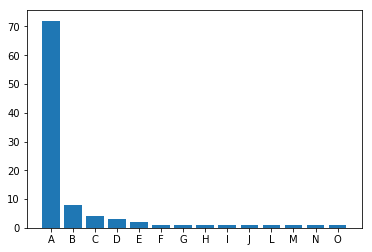

In [54]:
import matplotlib.pyplot as plt

# Omit the first class as the proportion won't allow to see the rest
ham_struct_types = ham_structures[1:,0]
ham_struct_counts = ham_structures[1:,1].astype(np.int)

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "L", "M", "N", "O"]
prop_iter = iter(plt.rcParams['axes.prop_cycle'])

for t, c in zip(classes, ham_struct_counts):
    plt.bar()
plt.bar(classes, ham_struct_counts)
plt.show()